In [ ]:
!pip install -U imbalanced-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 199 kB 7.0 MB/s 
     |████████████████████████████████| 199 kB 58.6 MB/s 
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.8.1
    Uninstalling imbalanced-learn-0.8.1:
      Successfully uninstalled imbalanced-learn-0.8.1


In [ ]:
!pip install ipython-autotime
%load_ext autotime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.6 MB 6.0 MB/s 
time: 476 µs (started: 2022-11-17 09:00:27 +00:00)


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.impute import SimpleImputer

In [ ]:
from collections import Counter
import pandas as pd

from imblearn.over_sampling import ADASYN
from sklearn.model_selection import cross_validate, train_test_split
from sklearn.ensemble import RandomForestClassifier
from imblearn.pipeline import make_pipeline
from imblearn.under_sampling import RandomUnderSampler

from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.metrics import roc_curve, roc_auc_score, auc, average_precision_score, f1_score,precision_score, recall_score,precision_recall_curve

import tensorflow as tf
from tensorflow import keras
from keras.utils import plot_model


seed = 66

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Processing

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/BT4012 Project/Submission Folder/Model Training Data/train_df.csv')
test_df = pd.read_csv('/content/drive/MyDrive/BT4012 Project/Submission Folder/Model Training Data/test_df.csv')

In [ ]:
# highly imbalanced dataset
print(sorted(Counter(train_df['Is_Fraud']).items()))

[(0.0, 210665), (1.0, 85)]


In [ ]:
X_train, y_train = train_df.drop(columns=["NPI", "Is_Fraud"]), train_df["Is_Fraud"]
X_test, y_test = test_df.drop(columns=["NPI", "Is_Fraud"]), test_df["Is_Fraud"]

print(sorted(Counter(y_train).items())) # training set is also very imbalanced

[(0.0, 210665), (1.0, 85)]


In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

In [ ]:
X_train_svm_smote = pd.read_csv('/content/drive/MyDrive/BT4012 Project/Submission Folder/Model Training Data/X_train_svm_smote.csv')
X_train_svm_smote_under = pd.read_csv('/content/drive/MyDrive/BT4012 Project/Submission Folder/Model Training Data/X_train_svm_smote_under.csv')
X_train_smote_enn = pd.read_csv('/content/drive/MyDrive/BT4012 Project/Submission Folder/Model Training Data/X_train_smote_enn.csv')
X_train_adasyn = pd.read_csv('/content/drive/MyDrive/BT4012 Project/Submission Folder/Model Training Data/X_train_adasyn.csv')

y_train_svm_smote_under = pd.read_csv('/content/drive/MyDrive/BT4012 Project/Submission Folder/Model Training Data/y_train_svm_smote_under.csv')
y_train_svm_smote = pd.read_csv('/content/drive/MyDrive/BT4012 Project/Submission Folder/Model Training Data/y_train_svm_smote.csv')
y_train_smote_enn = pd.read_csv('/content/drive/MyDrive/BT4012 Project/Submission Folder/Model Training Data/y_train_smote_enn.csv')
y_train_adasyn = pd.read_csv('/content/drive/MyDrive/BT4012 Project/Submission Folder/Model Training Data/y_train_adasyn.csv')

# Create MLP Model

In [ ]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_ann_model(metrics, input_dim):
  ann = tf.keras.models.Sequential()
  ann.add(tf.keras.layers.Input(shape=(input_dim, )))
  # Add the first hidden layer
  ann.add(tf.keras.layers.Dense(units=100, activation='relu'))
  # Add the second hidden layer
  ann.add(tf.keras.layers.Dense(units=80, activation='relu'))
  # Add the third hidden layer
  ann.add(tf.keras.layers.Dense(units=64, activation='relu'))
  # Add the fourth hidden layer
  ann.add(tf.keras.layers.Dense(units=32, activation='relu'))
  # Add the fifth hidden layer
  ann.add(tf.keras.layers.Dense(units=16, activation='relu'))
  # Add the sixth hidden layer
  ann.add(tf.keras.layers.Dense(units=8, activation='relu'))
  # Add the output layer
  ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

  ann.compile(optimizer = keras.optimizers.Adam(learning_rate=2e-4), loss = 'binary_crossentropy', metrics = metrics)

  return ann

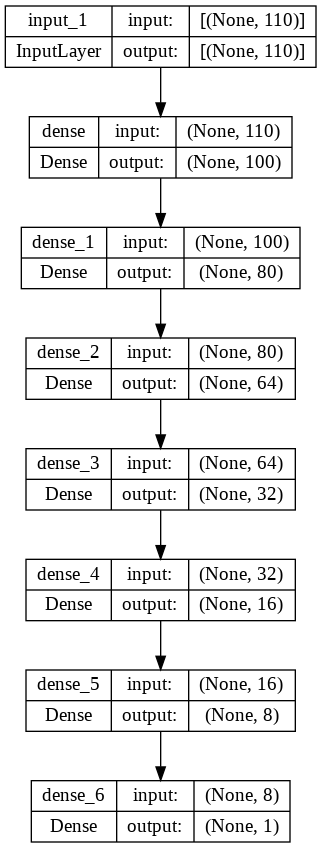

In [ ]:
temp_model_ann = make_ann_model(METRICS, X_train.shape[1])
plot_model(temp_model_ann,
           to_file="model.png",
           show_shapes=True,
           show_layer_names=True,
          )

In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

# Using Unbalanced Dataset

In [ ]:
ann_unbalanced = make_ann_model(METRICS, X_train.shape[1])

In [ ]:
ann_unbalanced_hist = ann_unbalanced.fit(X_train, y_train, validation_split=0.20, batch_size = 20, epochs = 50, callbacks =[earlystopping])

Epoch 1/50
8430/8430 [==============================] - 52s 6ms/step - loss: 0.0078 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 168532.0000 - fn: 68.0000 - accuracy: 0.9996 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5077 - prc: 4.3826e-04 - val_loss: 0.0045 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 42133.0000 - val_fn: 17.0000 - val_accuracy: 0.9996 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5291 - val_prc: 0.0022
Epoch 2/50
8430/8430 [==============================] - 36s 4ms/step - loss: 0.0038 - tp: 0.0000e+00 - fp: 0.0000e+00 - tn: 168532.0000 - fn: 68.0000 - accuracy: 0.9996 - precision: 0.0000e+00 - recall: 0.0000e+00 - auc: 0.5467 - prc: 0.0030 - val_loss: 0.0037 - val_tp: 0.0000e+00 - val_fp: 0.0000e+00 - val_tn: 42133.0000 - val_fn: 17.0000 - val_accuracy: 0.9996 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - val_auc: 0.5517 - val_prc: 0.0088
Epoch 3/50
8430/8430 [==============================] - 50s 6ms/step - loss: 0.0033 - tp

In [ ]:
preds = ann_unbalanced.predict(X_test)
ann_unbalanced_proba = np.array([item[0] for item in preds.tolist()])
ann_unbalanced_preds = np.argmax(preds, axis=1)

1647/1647 [==============================] - 3s 2ms/step


In [ ]:
ann_test_roc_auc = round(roc_auc_score(y_test, ann_unbalanced_proba), 4)
unbalanced_precision_score, unbalanced_recall_score, _ = precision_recall_curve(y_test, ann_unbalanced_proba)
ann_test_pr_auc = round(auc(unbalanced_recall_score, unbalanced_precision_score),5)

unbalanced_recall_score = recall_score(y_test, ann_unbalanced_preds)
unbalanced_precision_score = precision_score(y_test, ann_unbalanced_preds)
unbalanced_spec_score = recall_score(y_test, ann_unbalanced_preds,pos_label=0)

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
y_unbalanced_predicted = np.argmax(ann_unbalanced.predict(X_test) , axis=1)
cf_matrix_unbalanced = confusion_matrix(y_test, y_unbalanced_predicted)

1647/1647 [==============================] - 3s 2ms/step


In [ ]:
print(classification_report(y_test, y_unbalanced_predicted))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     52667
         1.0       0.00      0.00      0.00        21

    accuracy                           1.00     52688
   macro avg       0.50      0.50      0.50     52688
weighted avg       1.00      1.00      1.00     52688



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Text(33.0, 0.5, 'Ground Truth')

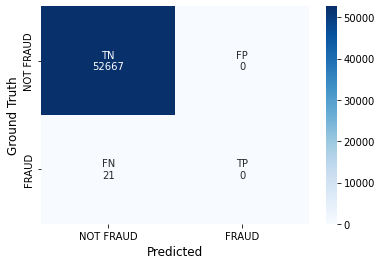

In [ ]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_unbalanced.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_unbalanced.flatten()/np.sum(cf_matrix_unbalanced)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels_unbalanced = np.asarray(labels).reshape(2,2)
s = sns.heatmap(cf_matrix_unbalanced, annot=labels_unbalanced, fmt='', cmap='Blues', xticklabels=['NOT FRAUD', 'FRAUD'], yticklabels=['NOT FRAUD', 'FRAUD'])
s.set_xlabel("Predicted", fontsize=12)
s.set_ylabel("Ground Truth", fontsize=12)

1647/1647 [==============================] - 4s 3ms/step


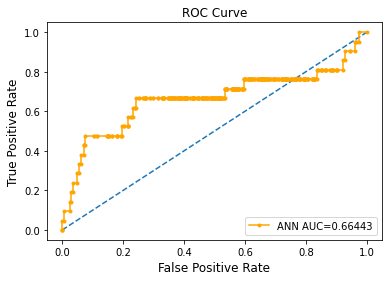

In [ ]:
ann_unbalanced_proba = ann_unbalanced.predict(X_test) 
ann_unbalanced_proba = np.array([item[0] for item in ann_unbalanced_proba.tolist()])
ann_fpr, ann_tpr, lr_threshold = roc_curve(y_test, ann_unbalanced_proba)
ann_auc = round(roc_auc_score(y_test, ann_unbalanced_proba),5)

ns_probs = [0 for _ in range(len(y_test))]
ns_fpr, ns_tpr, thresholds = roc_curve(y_test, ns_probs)

plt.plot(ns_fpr, ns_tpr, linestyle='--')
plt.plot(ann_fpr, ann_tpr, marker='.', label="ANN AUC="+str(ann_auc), color="orange")
plt.ylabel('True Positive Rate', fontsize=12)
plt.xlabel('False Positive Rate', fontsize=12)
plt.title('ROC Curve')
plt.legend(loc=4)
plt.show()

# Results

In [ ]:
test_data = {'Baseline': [ann_test_roc_auc , ann_test_pr_auc ,unbalanced_precision_score, unbalanced_recall_score, 1-unbalanced_spec_score ]}
test_result_df = pd.DataFrame(test_data, index=['ROC_AUC', 'PR_AUC', 'Precision', 'Recall', 'FPR'])

In [ ]:
test_result_df

,Baseline
ROC_AUC,0.66440
PR_AUC,0.00541
Precision,0.00000
Recall,0.00000
FPR,0.00000


Text(33.0, 0.5, 'Ground Truth')

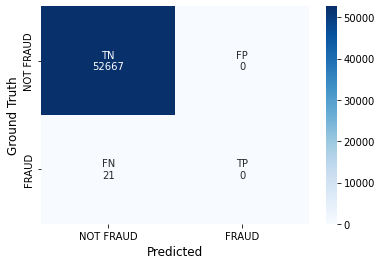

In [ ]:
group_names = ['TN','FP','FN','TP']
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix_unbalanced.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix_unbalanced.flatten()/np.sum(cf_matrix_unbalanced)]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
labels_unbalanced = np.asarray(labels).reshape(2,2)
s = sns.heatmap(cf_matrix_unbalanced, annot=labels_unbalanced, fmt='', cmap='Blues', xticklabels=['NOT FRAUD', 'FRAUD'], yticklabels=['NOT FRAUD', 'FRAUD'])
s.set_xlabel("Predicted", fontsize=12)
s.set_ylabel("Ground Truth", fontsize=12)